In [7]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version 2.1 --apt-packages libgoogleapi-dev libgl1-mesa-glx

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    14  100    14    0     0     30      0 --:--:-- --:--:-- --:--:--    30
  File "/content/pytorch-xla-env-setup.py", line 1
    404: Not Found
    ^^^
SyntaxError: illegal target for annotation


In [ ]:
# ======================================================================
# CELL 2: Imports (Versi Update)
# ======================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import time # <-- TAMBAHAN BARU DI SINI

# --- IMPORT UNTUK TPU (PyTorch/XLA) ---
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.runtime

# --- IMPORT UNTUK PROGRESS BAR ---
from tqdm.notebook import tqdm

print("Cell 2: Semua library berhasil di-import. (Termasuk 'time')")

A. Persiapan data. Jelaskan preprocessing yang diperlukan (tokenisasi/subword, max length, padding, train/val/test split, dsb.)

In [4]:
# ======================================================================
# CELL 3: Definisi Persiapan Data
# ======================================================================

# --- Class Vocabulary ---
class Vocabulary:
    def __init__(self):
        # [PAD] = 0
        self.word2idx = {"[PAD]": 0, "[UNK]": 1, "[CLS]": 2}
        self.idx2word = {0: "[PAD]", 1: "[UNK]", 2: "[CLS]"}
        self.idx = 3
    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1
    def __len__(self):
        return len(self.word2idx)

# --- Class Dataset ---
class SentimentDataset(Dataset):
    def __init__(self, data, vocab, max_len):
        self.data = data
        self.vocab = vocab
        self.max_len = max_len
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        sentence, label = self.data[idx]
        tokens = ["[CLS]"] + str(sentence).split()
        token_ids = [self.vocab.word2idx.get(w, self.vocab.word2idx["[UNK]"]) for w in tokens]
        token_ids = token_ids[:self.max_len]
        return torch.tensor(token_ids), label # Perbaikan TypeError

# --- Fungsi Collate (Padding) ---
def collate_fn(batch):
    token_ids, labels = zip(*batch)
    max_len_in_batch = max(len(t) for t in token_ids)

    # [PAD] token adalah 0, jadi kita fill_value=0
    padded_tokens = torch.full((len(batch), max_len_in_batch),
                               fill_value=0, # Perbaikan: [PAD] adalah 0
                               dtype=torch.long)
    padding_mask = torch.zeros((len(batch), max_len_in_batch), dtype=torch.bool)

    for i, tokens in enumerate(token_ids):
        seq_len = len(tokens)
        padded_tokens[i, :seq_len] = tokens
        padding_mask[i, seq_len:] = True

    labels = torch.tensor(labels, dtype=torch.long)
    return padded_tokens, padding_mask, labels

# --- Fungsi Utama Prepare Data ---
def prepare_data():
    """Fungsi untuk load dan proses data, mengembalikan data loader."""

    file_path = '7-garudaindonesia_news_cleaned_simple.csv' # Pastikan nama file BENAR
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        xm.master_print(f"ERROR: File '7-garudaindonesia_news_cleaned_simple.csv' tidak ditemukan.")
        return None

    # Preprocessing & Label Mapping
    df = df.dropna(subset=['konten_normalized', 'sentiment'])
    label_map = {'Positive': 1, 'Negative': 0}
    df['label'] = df['sentiment'].map(label_map)

    # PERBAIKAN 'nan'
    df = df.dropna(subset=['label'])
    df['label'] = df['label'].astype(int)

    data_tuples = list(zip(df['konten_normalized'], df['label']))

    xm.master_print(f"Total data yang akan dipakai: {len(data_tuples)} baris")
    if len(data_tuples) > 0:
        xm.master_print(f"Contoh data (setelah bersih): {data_tuples[0]}")
    else:
        xm.master_print("ERROR: Tidak ada data valid setelah mapping label.")
        return None

    # Build Vocab
    xm.master_print("Membangun vocabulary...")
    vocab = Vocabulary()
    for sentence, _ in data_tuples:
        for word in str(sentence).split():
            vocab.add_word(word)

    VOCAB_SIZE = len(vocab)
    lengths = [len(str(s).split()) for s, _ in data_tuples]
    MAX_LEN = int(np.percentile(lengths, 95))

    xm.master_print(f"Ukuran Vocabulary: {VOCAB_SIZE}")
    xm.master_print(f"MAX_LEN di-set ke: {MAX_LEN} (95th percentile)")

    # Train/Val Split
    dataset = SentimentDataset(data_tuples, vocab, MAX_LEN)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    xm.master_print(f"Data latih: {len(train_dataset)}, Data validasi: {len(val_dataset)}")

    # KEMBALIKAN SEMUA YANG DIBUTUHKAN
    return train_dataset, val_dataset, vocab, MAX_LEN, VOCAB_SIZE, collate_fn

print("Cell 3 (Persiapan Data) siap.")

Cell 3 (Persiapan Data) siap.


B. Model awal. Jelaskan desain arsitektur Transformer (embedding dim, positional encoding, #heads, #layers, feed-forward dim, dropout, classifier head), inisialisasi, optimizer, loss;

a) Latih model awal dengan konfigurasi default (mis. lr=1e-4, batch=32, epochs=10) dan laporkan sebagai performance awal.

b) Simpan loss & metric (train & val) per epoch dan tampilkan grafik loss/accuracy training vs validation

c) Jelaskan apakah model mengalami underfit/baik/overfit pada konfigurasi awal ini.


In [5]:
# ======================================================================
# CELL 4: Definisi Arsitektur Model
# ======================================================================

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % n_heads == 0, "d_model harus bisa dibagi n_heads"
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.d_k]))
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        Q = self.W_q(query)
        K = self.W_k(key)
        V = self.W_v(value)
        Q = Q.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        # Pindahkan scale ke device yang benar saat forward pass
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale.to(query.device)
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(2)
            scores = scores.masked_fill(mask == True, -1e9)
        attention = torch.softmax(scores, dim=-1)
        attention = self.dropout(attention)
        context = torch.matmul(attention, V)
        context = context.transpose(1, 2).contiguous()
        context = context.view(batch_size, -1, self.d_model)
        output = self.W_o(context)
        return output

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, ff_dim, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, ff_dim)
        self.linear2 = nn.Linear(ff_dim, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        return self.dropout(self.linear2(self.relu(self.linear1(x))))

class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, ff_dim, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.ffn = PositionwiseFeedForward(d_model, ff_dim, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
    def forward(self, x, mask):
        attn_output = self.attn(x, x, x, mask)
        x = self.norm1(x + self.dropout1(attn_output))
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout2(ffn_output))
        return x

class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, n_heads, num_layers, ff_dim, num_classes=2, dropout=0.1, max_len=5000):
        super(SentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim, dropout, max_len)
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(embed_dim, n_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)
        self.classifier_head = nn.Linear(embed_dim, num_classes)
    def forward(self, src, src_mask):
        embedded = self.embedding(src)
        embedded = self.pos_encoder(embedded)
        output = embedded
        for layer in self.encoder_layers:
            output = layer(output, src_mask)
        cls_output = output[:, 0, :]
        cls_output = self.dropout(cls_output)
        logits = self.classifier_head(cls_output)
        return logits

print("Cell 4 (Arsitektur Model) siap.")

Cell 4 (Arsitektur Model) siap.


In [6]:
# ======================================================================
# CELL 5: Definisi Fungsi Training & Validasi (FIXED 100%)
# ======================================================================

def train_epoch(model, loader, optimizer, criterion, device, num_batches, epoch_num, total_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    pbar = None
    # --- PERBAIKAN DI SINI: Pake 'runtime.global_ordinal()' ---
    if torch_xla.runtime.global_ordinal() == 0:
        pbar = tqdm(total=num_batches,
                    desc=f'Epoch {epoch_num}/{total_epochs} Train',
                    leave=False)

    for tokens, mask, labels in loader:
        optimizer.zero_grad()
        logits = model(tokens, mask)
        loss = criterion(logits, labels)
        loss.backward()
        xm.optimizer_step(optimizer, barrier=True)

        total_loss += loss.item() * tokens.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += tokens.size(0)

        # --- PERBAIKAN DI SINI ---
        if torch_xla.runtime.global_ordinal() == 0:
            pbar.update(1)

    # --- PERBAIKAN DI SINI ---
    if torch_xla.runtime.global_ordinal() == 0:
        pbar.close()

    if total_samples == 0: return 0.0, 0.0
    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    return avg_loss, avg_acc

def validate_epoch(model, loader, criterion, device, num_batches, epoch_num, total_epochs):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    pbar = None
    # --- PERBAIKAN DI SINI ---
    if torch_xla.runtime.global_ordinal() == 0:
        pbar = tqdm(total=num_batches,
                    desc=f'Epoch {epoch_num}/{total_epochs} Val  ',
                    leave=False)

    with torch.no_grad():
        for tokens, mask, labels in loader:
            logits = model(tokens, mask)
            loss = criterion(logits, labels)

            total_loss += loss.item() * tokens.size(0)
            preds = logits.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += tokens.size(0)

            # --- PERBAIKAN DI SINI ---
            if torch_xla.runtime.global_ordinal() == 0:
                pbar.update(1)

    # --- PERBAIKAN DI SINI ---
    if torch_xla.runtime.global_ordinal() == 0:
        pbar.close()

    if total_samples == 0: return 0.0, 0.0
    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    return avg_loss, avg_acc

print("Cell 5 (Fungsi Train/Val) siap. (v2.8.0 fix, take 4)")

Cell 5 (Fungsi Train/Val) siap. (v2.8.0 fix, take 4)


Using device: xla:0
Total data yang akan dipakai: 384 baris
Contoh data (setelah bersih): ('jakarta ketua komisi v dpr lasarus mengatakan mendalami laporan dugaan adanya mafia jual beli jam penerbangan di industri aviasi tanah air dalam rapat mendatang dengan kementerian perhubungan serta maskapai pernyataan tersebut menanggapi kabar dugaan adanya mafia jual beli jam penerbangan kecurigaan adanya mafia ini berawal dari tidak adanya penerbangan garuda indonesia di jam jam favorit begitu juga dengan anak usaha garuda indonesia citilink indonesia iya kita coba tanya kita bahas lah kalau benar nanti kita dalami ini kan informasi yang bagus katanya kepada voi senin september meski begitu lasarus mengaku maskapai garuda indonesia selama ini juga tidak pernah mengeluhkan terkait jam penerbangan atau slot time yang diberikan kepada maskapai tersebut adapun slot time adalah jadwal resmi yang diberikan otoritas bandara kepada maskapai untuk melakukan take off atau landingdi bandara tertentu maka

Epoch 1/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


Epoch 1/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.8943 | Train Acc: 0.4853 | Val Loss: 0.8054 | Val Acc: 0.4416


Epoch 2/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.7371 | Train Acc: 0.4756 | Val Loss: 0.6921 | Val Acc: 0.5584


Epoch 3/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.6921 | Train Acc: 0.5179 | Val Loss: 0.6826 | Val Acc: 0.5584


Epoch 4/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.7087 | Train Acc: 0.5244 | Val Loss: 0.6812 | Val Acc: 0.5584


Epoch 5/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.6940 | Train Acc: 0.5244 | Val Loss: 0.6832 | Val Acc: 0.5584


Epoch 6/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.6986 | Train Acc: 0.5212 | Val Loss: 0.6853 | Val Acc: 0.6104


Epoch 7/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.6995 | Train Acc: 0.5407 | Val Loss: 0.6801 | Val Acc: 0.5714


Epoch 8/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.6948 | Train Acc: 0.5635 | Val Loss: 0.6768 | Val Acc: 0.5584


Epoch 9/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.7109 | Train Acc: 0.5016 | Val Loss: 0.6744 | Val Acc: 0.5584


Epoch 10/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.6914 | Train Acc: 0.5179 | Val Loss: 0.6751 | Val Acc: 0.6753


Epoch 11/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.6869 | Train Acc: 0.5472 | Val Loss: 0.6706 | Val Acc: 0.6234


Epoch 12/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.6833 | Train Acc: 0.5212 | Val Loss: 0.6696 | Val Acc: 0.7143


Epoch 13/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.6677 | Train Acc: 0.6254 | Val Loss: 0.6639 | Val Acc: 0.6753


Epoch 14/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.6674 | Train Acc: 0.6091 | Val Loss: 0.6587 | Val Acc: 0.6753


Epoch 15/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.6552 | Train Acc: 0.6091 | Val Loss: 0.6550 | Val Acc: 0.6883


Epoch 16/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.6605 | Train Acc: 0.5961 | Val Loss: 0.6484 | Val Acc: 0.6623


Epoch 17/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.6409 | Train Acc: 0.6352 | Val Loss: 0.6400 | Val Acc: 0.6494


Epoch 18/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.6378 | Train Acc: 0.6319 | Val Loss: 0.6371 | Val Acc: 0.6494


Epoch 19/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.6198 | Train Acc: 0.6482 | Val Loss: 0.6304 | Val Acc: 0.6234


Epoch 20/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.5965 | Train Acc: 0.7394 | Val Loss: 0.6269 | Val Acc: 0.6623

--- Performance Awal (Epoch Terakhir) ---
Final Train Loss: 0.5965
Final Train Acc: 0.7394
Final Val Loss: 0.6269
Final Val Acc: 0.6623

Membuat grafik...


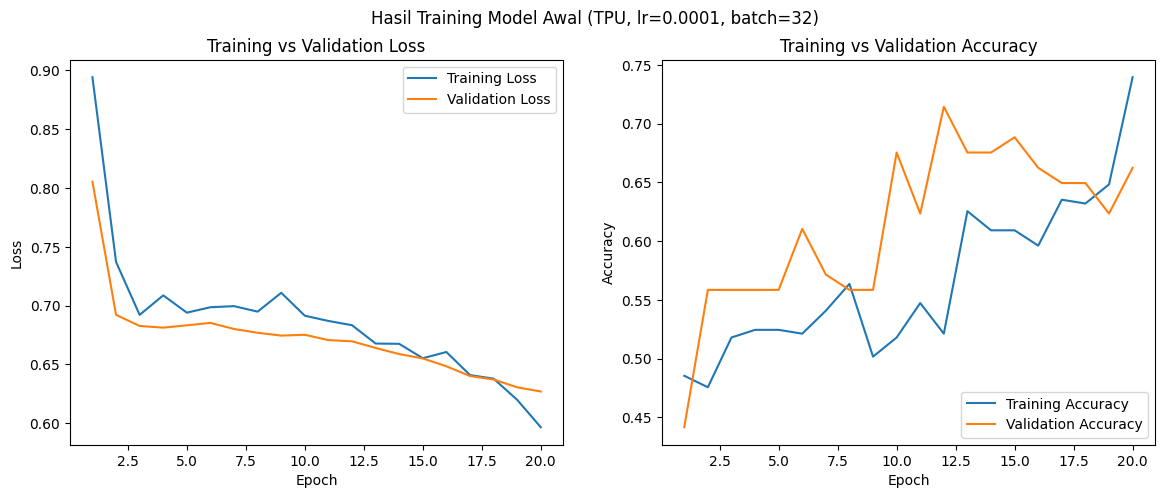

Grafik disimpan sebagai 'training_plots_tpu.png'


In [7]:
# ======================================================================
# CELL 6: Main Training (Eksekusi) (FIXED 100%)
# ======================================================================

def main_training():
    # --- Konfigurasi ---
    EMBED_DIM = 64
    N_HEADS = 4
    NUM_LAYERS = 2
    FF_DIM = 128
    DROPOUT = 0.1
    NUM_CLASSES = 2
    LEARNING_RATE = 1e-4
    BATCH_SIZE = 32
    EPOCHS = 20

    # --- PENGATURAN TPU ---
    device = torch_xla.device()
    xm.master_print(f"Using device: {device}")

    # --- Siapkan data ---
    data_prep_results = prepare_data()
    if data_prep_results is None:
        xm.master_print("Gagal memproses data. Training dibatalkan.")
        return

    train_dataset, val_dataset, vocab, MAX_LEN, VOCAB_SIZE, collate_fn_from_prep = data_prep_results

    # --- Buat DataLoaders ---
    train_loader_base = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_from_prep, num_workers=4)
    val_loader_base = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_from_prep, num_workers=4)
    train_loader = pl.MpDeviceLoader(train_loader_base, device)
    val_loader = pl.MpDeviceLoader(val_loader_base, device)

    # --- Inisialisasi Model ---
    model = SentimentClassifier(
        vocab_size=VOCAB_SIZE,
        embed_dim=EMBED_DIM,
        n_heads=N_HEADS,
        num_layers=NUM_LAYERS,
        ff_dim=FF_DIM,
        num_classes=NUM_CLASSES,
        dropout=DROPOUT,
        max_len=MAX_LEN + 1
    ).to(device)

    # --- Optimizer dan Loss ---
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    # --- Training Loop ---
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    xm.master_print("Mulai training model awal (dengan data CSV di TPU)...")

    for epoch in range(EPOCHS):
        num_train_batches = len(train_loader_base)
        num_val_batches = len(val_loader_base)

        train_loss, train_acc = train_epoch(
            model, train_loader, optimizer, criterion, device,
            num_train_batches, epoch + 1, EPOCHS
        )
        val_loss, val_acc = validate_epoch(
            model, val_loader, criterion, device,
            num_val_batches, epoch + 1, EPOCHS
        )

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        xm.master_print(f"Epoch {epoch+1}/{EPOCHS} | "
                      f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                      f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    xm.master_print("\n--- Performance Awal (Epoch Terakhir) ---")
    xm.master_print(f"Final Train Loss: {history['train_loss'][-1]:.4f}")
    xm.master_print(f"Final Train Acc: {history['train_acc'][-1]:.4f}")
    xm.master_print(f"Final Val Loss: {history['val_loss'][-1]:.4f}")
    xm.master_print(f"Final Val Acc: {history['val_acc'][-1]:.4f}")

    # --- Tampilkan Grafik ---
    # --- PERBAIKAN DI SINI ---
    if torch_xla.runtime.global_ordinal() == 0:
        xm.master_print("\nMembuat grafik...")
        epochs_range = range(1, EPOCHS + 1)
        plt.figure(figsize=(14, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, history['train_loss'], label='Training Loss')
        plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training vs Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
        plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training vs Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')

        plt.suptitle(f'Hasil Training Model Awal (TPU, lr={LEARNING_RATE}, batch={BATCH_SIZE})')
        plt.savefig('training_plots_tpu.png')
        plt.show()
        xm.master_print("Grafik disimpan sebagai 'training_plots_tpu.png'")


# --- Jalankan Training ---
if __name__ == '__main__':
    main_training()

C. Eksperimen untuk meningkatkan performa. Rancang sejumlah rangkaian eksperimen sistematis:

a) Ubah epoch misal sampai 50 dan amati apakah terjadi overfitting (buktikan dengan grafik dan metrik)

b) Lakukan variasi hyperparameter arsitektur, minimal terdapat satu kali perubahan untuk setiap parameter: misal adalah jumlah head (mis. 2,4,8), jumlah encoder layers (mis. 1,2,4), embed_dim (64,128,256), dropout (0.1–0.5).

In [9]:
# ======================================================================
# CELL 7: Fungsi Plotting (Baru)
# ======================================================================

def plot_history(history, title):
    """Fungsi helper untuk nge-plot loss dan accuracy."""

    # Fungsi ini HANYA jalan di master process
    if torch_xla.runtime.global_ordinal() != 0:
        return

    epochs_range = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_loss'], label='Training Loss')
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.suptitle(title)

    # Ganti karakter ilegal di nama file
    filename = title.lower().replace(' ', '_').replace('=', '').replace('.', '').replace(':', '') + '.png'
    plt.savefig(filename)
    plt.show()

    xm.master_print(f"Grafik disimpan sebagai: {filename}")

print("Cell 7 (Fungsi Plotting) siap.")

Cell 7 (Fungsi Plotting) siap.


Menyiapkan data satu kali untuk semua eksperimen...
Total data yang akan dipakai: 384 baris
Contoh data (setelah bersih): ('jakarta ketua komisi v dpr lasarus mengatakan mendalami laporan dugaan adanya mafia jual beli jam penerbangan di industri aviasi tanah air dalam rapat mendatang dengan kementerian perhubungan serta maskapai pernyataan tersebut menanggapi kabar dugaan adanya mafia jual beli jam penerbangan kecurigaan adanya mafia ini berawal dari tidak adanya penerbangan garuda indonesia di jam jam favorit begitu juga dengan anak usaha garuda indonesia citilink indonesia iya kita coba tanya kita bahas lah kalau benar nanti kita dalami ini kan informasi yang bagus katanya kepada voi senin september meski begitu lasarus mengaku maskapai garuda indonesia selama ini juga tidak pernah mengeluhkan terkait jam penerbangan atau slot time yang diberikan kepada maskapai tersebut adapun slot time adalah jadwal resmi yang diberikan otoritas bandara kepada maskapai untuk melakukan take off atau

Epoch 1/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 0.8147 | Train Acc: 0.4430 | Val Loss: 0.7049 | Val Acc: 0.4935


Epoch 2/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 0.7042 | Train Acc: 0.4919 | Val Loss: 0.6985 | Val Acc: 0.4805


Epoch 3/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.7169 | Train Acc: 0.4984 | Val Loss: 0.7023 | Val Acc: 0.5065


Epoch 4/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.7030 | Train Acc: 0.5505 | Val Loss: 0.6908 | Val Acc: 0.4805


Epoch 5/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.7250 | Train Acc: 0.4788 | Val Loss: 0.6871 | Val Acc: 0.5195


Epoch 6/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.6878 | Train Acc: 0.5440 | Val Loss: 0.6848 | Val Acc: 0.5325


Epoch 7/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.6910 | Train Acc: 0.5505 | Val Loss: 0.6838 | Val Acc: 0.4935


Epoch 8/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.6894 | Train Acc: 0.5700 | Val Loss: 0.6801 | Val Acc: 0.5325


Epoch 9/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.6918 | Train Acc: 0.5114 | Val Loss: 0.6776 | Val Acc: 0.5714


Epoch 10/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.6788 | Train Acc: 0.5537 | Val Loss: 0.6750 | Val Acc: 0.5065


Epoch 11/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.6924 | Train Acc: 0.5635 | Val Loss: 0.6744 | Val Acc: 0.5325


Epoch 12/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.6720 | Train Acc: 0.5440 | Val Loss: 0.6690 | Val Acc: 0.5714


Epoch 13/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.6797 | Train Acc: 0.5700 | Val Loss: 0.6659 | Val Acc: 0.5844


Epoch 14/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.6814 | Train Acc: 0.5440 | Val Loss: 0.6630 | Val Acc: 0.5325


Epoch 15/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.6679 | Train Acc: 0.5928 | Val Loss: 0.6594 | Val Acc: 0.5584


Epoch 16/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.6910 | Train Acc: 0.5407 | Val Loss: 0.6548 | Val Acc: 0.6883


Epoch 17/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.6556 | Train Acc: 0.6156 | Val Loss: 0.6553 | Val Acc: 0.5844


Epoch 18/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.6668 | Train Acc: 0.6091 | Val Loss: 0.6479 | Val Acc: 0.5714


Epoch 19/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.6557 | Train Acc: 0.6189 | Val Loss: 0.6383 | Val Acc: 0.6753


Epoch 20/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.6535 | Train Acc: 0.6482 | Val Loss: 0.6304 | Val Acc: 0.7403


Epoch 21/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.6319 | Train Acc: 0.6417 | Val Loss: 0.6204 | Val Acc: 0.7532


Epoch 22/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.6258 | Train Acc: 0.6808 | Val Loss: 0.6074 | Val Acc: 0.7532


Epoch 23/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.6201 | Train Acc: 0.7003 | Val Loss: 0.5924 | Val Acc: 0.7013


Epoch 24/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.5975 | Train Acc: 0.6775 | Val Loss: 0.5686 | Val Acc: 0.7532


Epoch 25/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.5885 | Train Acc: 0.6938 | Val Loss: 0.5450 | Val Acc: 0.7532


Epoch 26/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.5722 | Train Acc: 0.7003 | Val Loss: 0.5213 | Val Acc: 0.7532


Epoch 27/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.5446 | Train Acc: 0.7199 | Val Loss: 0.4963 | Val Acc: 0.7662


Epoch 28/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.5417 | Train Acc: 0.7459 | Val Loss: 0.4716 | Val Acc: 0.7662


Epoch 29/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.5079 | Train Acc: 0.7524 | Val Loss: 0.4461 | Val Acc: 0.8312


Epoch 30/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.4802 | Train Acc: 0.7883 | Val Loss: 0.4268 | Val Acc: 0.7662


Epoch 31/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 31/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.4719 | Train Acc: 0.7883 | Val Loss: 0.4038 | Val Acc: 0.8442


Epoch 32/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 32/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.4304 | Train Acc: 0.8111 | Val Loss: 0.3832 | Val Acc: 0.8442


Epoch 33/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 33/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.4285 | Train Acc: 0.8078 | Val Loss: 0.3636 | Val Acc: 0.8312


Epoch 34/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 34/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.4074 | Train Acc: 0.8404 | Val Loss: 0.3390 | Val Acc: 0.8442


Epoch 35/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 35/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.4108 | Train Acc: 0.8078 | Val Loss: 0.3344 | Val Acc: 0.8312


Epoch 36/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 36/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.3603 | Train Acc: 0.8469 | Val Loss: 0.3157 | Val Acc: 0.8442


Epoch 37/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 37/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.3495 | Train Acc: 0.8469 | Val Loss: 0.2971 | Val Acc: 0.8701


Epoch 38/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 38/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.3347 | Train Acc: 0.8339 | Val Loss: 0.3008 | Val Acc: 0.8571


Epoch 39/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 39/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.2975 | Train Acc: 0.8795 | Val Loss: 0.2895 | Val Acc: 0.8571


Epoch 40/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 40/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.2733 | Train Acc: 0.9088 | Val Loss: 0.2835 | Val Acc: 0.8571


Epoch 41/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 41/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.2619 | Train Acc: 0.8958 | Val Loss: 0.2808 | Val Acc: 0.8571


Epoch 42/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 42/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.2516 | Train Acc: 0.9186 | Val Loss: 0.2704 | Val Acc: 0.8701


Epoch 43/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 43/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.2414 | Train Acc: 0.8990 | Val Loss: 0.2657 | Val Acc: 0.8961


Epoch 44/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 44/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.2380 | Train Acc: 0.9023 | Val Loss: 0.2876 | Val Acc: 0.8701


Epoch 45/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 45/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.2012 | Train Acc: 0.9088 | Val Loss: 0.2447 | Val Acc: 0.8961


Epoch 46/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 46/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.1849 | Train Acc: 0.9283 | Val Loss: 0.2751 | Val Acc: 0.8701


Epoch 47/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 47/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.1666 | Train Acc: 0.9349 | Val Loss: 0.2341 | Val Acc: 0.8961


Epoch 48/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 48/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.1744 | Train Acc: 0.9283 | Val Loss: 0.3131 | Val Acc: 0.8312


Epoch 49/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 49/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.2172 | Train Acc: 0.9055 | Val Loss: 0.2226 | Val Acc: 0.8961


Epoch 50/50 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 50/50 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.1637 | Train Acc: 0.9349 | Val Loss: 0.2666 | Val Acc: 0.8571

--- Hasil Eksperimen: C1_Epochs_50 ---
Waktu Training Total: 307.06 detik
Final Train Loss: 0.1637
Final Train Acc: 0.9349
Final Val Loss: 0.2666
Final Val Acc: 0.8571


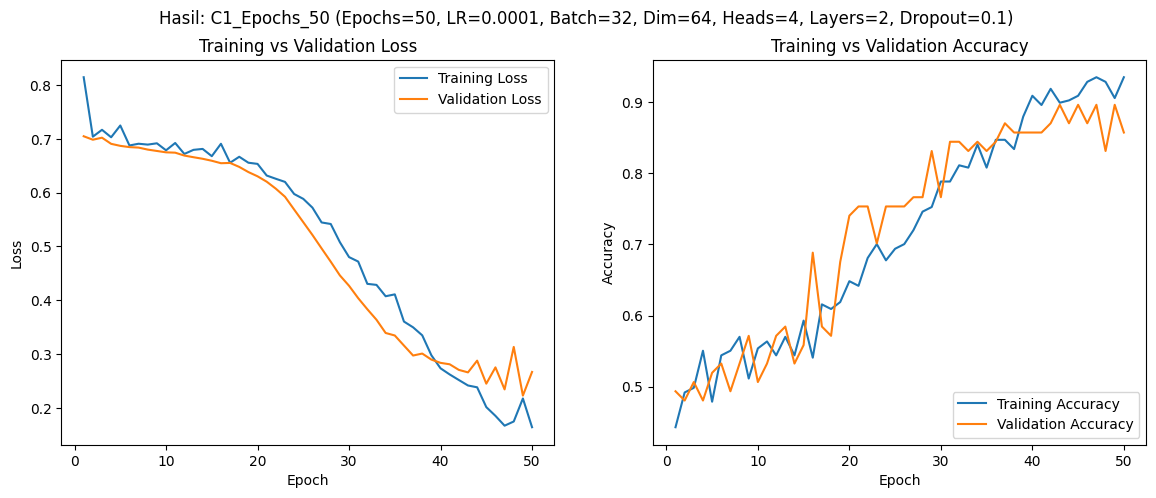

Grafik disimpan sebagai: hasil_c1_epochs_50_(epochs50,_lr00001,_batch32,_dim64,_heads4,_layers2,_dropout01).png

MULAI EKSPERIMEN: C2_Heads_2
Konfigurasi: {'lr': 0.0001, 'batch_size': 32, 'embed_dim': 64, 'n_heads': 2, 'num_layers': 2, 'ff_dim': 128, 'dropout': 0.1, 'epochs': 20, 'weight_decay': 0.0, 'name': 'C2_Heads_2'}


Epoch 1/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.7038 | Train Acc: 0.5147 | Val Loss: 0.6870 | Val Acc: 0.5195


Epoch 2/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.7086 | Train Acc: 0.5114 | Val Loss: 0.6876 | Val Acc: 0.5065


Epoch 3/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.6998 | Train Acc: 0.5212 | Val Loss: 0.6834 | Val Acc: 0.5974


Epoch 4/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.6898 | Train Acc: 0.5212 | Val Loss: 0.6812 | Val Acc: 0.6234


Epoch 5/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.7040 | Train Acc: 0.5081 | Val Loss: 0.6791 | Val Acc: 0.6104


Epoch 6/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.6890 | Train Acc: 0.5570 | Val Loss: 0.6773 | Val Acc: 0.6234


Epoch 7/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.6943 | Train Acc: 0.5016 | Val Loss: 0.6746 | Val Acc: 0.6623


Epoch 8/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.6955 | Train Acc: 0.5309 | Val Loss: 0.6721 | Val Acc: 0.6364


Epoch 9/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.7008 | Train Acc: 0.5309 | Val Loss: 0.6702 | Val Acc: 0.6104


Epoch 10/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.6751 | Train Acc: 0.5928 | Val Loss: 0.6673 | Val Acc: 0.6234


Epoch 11/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.6786 | Train Acc: 0.5603 | Val Loss: 0.6630 | Val Acc: 0.6623


Epoch 12/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.6747 | Train Acc: 0.5472 | Val Loss: 0.6597 | Val Acc: 0.6494


Epoch 13/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.6651 | Train Acc: 0.6189 | Val Loss: 0.6546 | Val Acc: 0.6623


Epoch 14/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.6441 | Train Acc: 0.6645 | Val Loss: 0.6491 | Val Acc: 0.6883


Epoch 15/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.6588 | Train Acc: 0.5863 | Val Loss: 0.6422 | Val Acc: 0.7662


Epoch 16/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.6511 | Train Acc: 0.6352 | Val Loss: 0.6353 | Val Acc: 0.6883


Epoch 17/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.6459 | Train Acc: 0.6287 | Val Loss: 0.6252 | Val Acc: 0.7922


Epoch 18/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.6205 | Train Acc: 0.6840 | Val Loss: 0.6148 | Val Acc: 0.8312


Epoch 19/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.6225 | Train Acc: 0.6612 | Val Loss: 0.6012 | Val Acc: 0.7792


Epoch 20/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.6011 | Train Acc: 0.7199 | Val Loss: 0.5837 | Val Acc: 0.7922

--- Hasil Eksperimen: C2_Heads_2 ---
Waktu Training Total: 422.71 detik
Final Train Loss: 0.6011
Final Train Acc: 0.7199
Final Val Loss: 0.5837
Final Val Acc: 0.7922


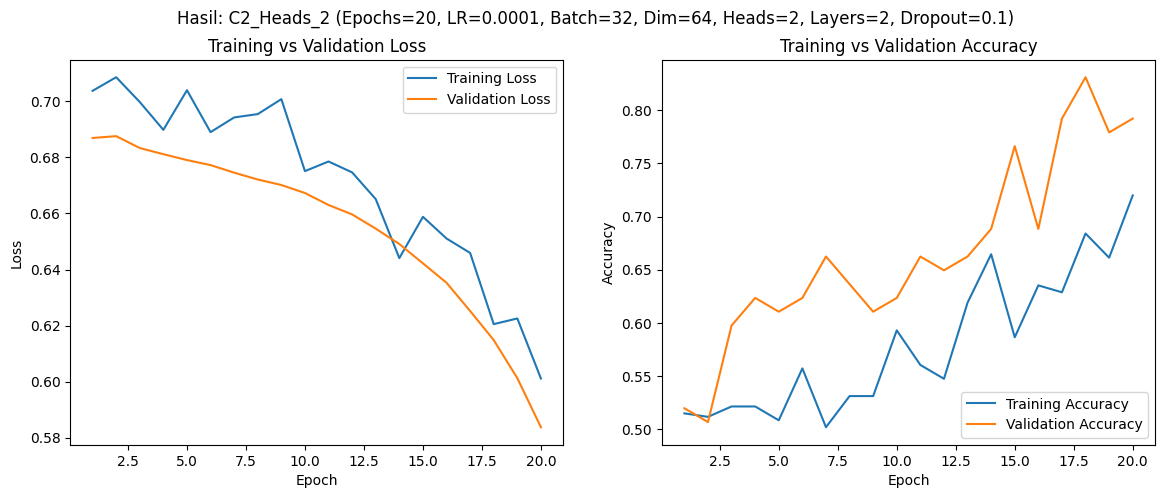

Grafik disimpan sebagai: hasil_c2_heads_2_(epochs20,_lr00001,_batch32,_dim64,_heads2,_layers2,_dropout01).png

MULAI EKSPERIMEN: C2_Heads_8
Konfigurasi: {'lr': 0.0001, 'batch_size': 32, 'embed_dim': 64, 'n_heads': 8, 'num_layers': 2, 'ff_dim': 128, 'dropout': 0.1, 'epochs': 20, 'weight_decay': 0.0, 'name': 'C2_Heads_8'}


Epoch 1/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.7437 | Train Acc: 0.4919 | Val Loss: 0.7028 | Val Acc: 0.4935


Epoch 2/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.7346 | Train Acc: 0.4104 | Val Loss: 0.6971 | Val Acc: 0.4805


Epoch 3/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.6846 | Train Acc: 0.5570 | Val Loss: 0.6947 | Val Acc: 0.4935


Epoch 4/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.6992 | Train Acc: 0.4951 | Val Loss: 0.6933 | Val Acc: 0.5065


Epoch 5/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.7183 | Train Acc: 0.5114 | Val Loss: 0.6929 | Val Acc: 0.5065


Epoch 6/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.7091 | Train Acc: 0.5114 | Val Loss: 0.6880 | Val Acc: 0.5195


Epoch 7/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.6940 | Train Acc: 0.5212 | Val Loss: 0.6849 | Val Acc: 0.5325


Epoch 8/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.6971 | Train Acc: 0.5212 | Val Loss: 0.6840 | Val Acc: 0.5195


Epoch 9/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.7077 | Train Acc: 0.4886 | Val Loss: 0.6815 | Val Acc: 0.5195


Epoch 10/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.7029 | Train Acc: 0.5016 | Val Loss: 0.6778 | Val Acc: 0.5325


Epoch 11/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.6835 | Train Acc: 0.5505 | Val Loss: 0.6740 | Val Acc: 0.6883


Epoch 12/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.7043 | Train Acc: 0.5212 | Val Loss: 0.6716 | Val Acc: 0.6234


Epoch 13/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.6818 | Train Acc: 0.5570 | Val Loss: 0.6725 | Val Acc: 0.5065


Epoch 14/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.6959 | Train Acc: 0.5472 | Val Loss: 0.6637 | Val Acc: 0.7013


Epoch 15/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.6946 | Train Acc: 0.5212 | Val Loss: 0.6613 | Val Acc: 0.6364


Epoch 16/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.6765 | Train Acc: 0.5765 | Val Loss: 0.6557 | Val Acc: 0.7273


Epoch 17/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.6699 | Train Acc: 0.5831 | Val Loss: 0.6532 | Val Acc: 0.6234


Epoch 18/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.6596 | Train Acc: 0.6221 | Val Loss: 0.6461 | Val Acc: 0.6494


Epoch 19/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.6682 | Train Acc: 0.5668 | Val Loss: 0.6392 | Val Acc: 0.6623


Epoch 20/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.6479 | Train Acc: 0.6645 | Val Loss: 0.6283 | Val Acc: 0.7532

--- Hasil Eksperimen: C2_Heads_8 ---
Waktu Training Total: 406.20 detik
Final Train Loss: 0.6479
Final Train Acc: 0.6645
Final Val Loss: 0.6283
Final Val Acc: 0.7532


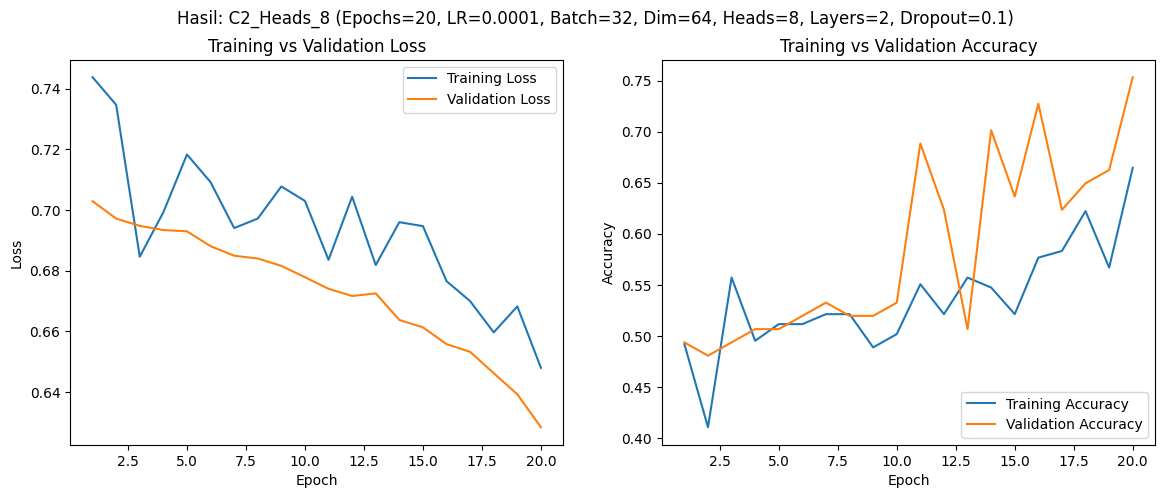

Grafik disimpan sebagai: hasil_c2_heads_8_(epochs20,_lr00001,_batch32,_dim64,_heads8,_layers2,_dropout01).png

MULAI EKSPERIMEN: C2_Layers_1
Konfigurasi: {'lr': 0.0001, 'batch_size': 32, 'embed_dim': 64, 'n_heads': 4, 'num_layers': 1, 'ff_dim': 128, 'dropout': 0.1, 'epochs': 20, 'weight_decay': 0.0, 'name': 'C2_Layers_1'}


Epoch 1/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.7146 | Train Acc: 0.5114 | Val Loss: 0.6932 | Val Acc: 0.5195


Epoch 2/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.7319 | Train Acc: 0.4886 | Val Loss: 0.6926 | Val Acc: 0.5065


Epoch 3/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.7182 | Train Acc: 0.4951 | Val Loss: 0.6917 | Val Acc: 0.5065


Epoch 4/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.7299 | Train Acc: 0.4951 | Val Loss: 0.6908 | Val Acc: 0.5065


Epoch 5/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.6947 | Train Acc: 0.5635 | Val Loss: 0.6897 | Val Acc: 0.5065


Epoch 6/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.7309 | Train Acc: 0.4560 | Val Loss: 0.6891 | Val Acc: 0.5065


Epoch 7/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.7121 | Train Acc: 0.5049 | Val Loss: 0.6892 | Val Acc: 0.5065


Epoch 8/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.7402 | Train Acc: 0.4625 | Val Loss: 0.6885 | Val Acc: 0.5065


Epoch 9/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.7074 | Train Acc: 0.5147 | Val Loss: 0.6850 | Val Acc: 0.5065


Epoch 10/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.6912 | Train Acc: 0.5472 | Val Loss: 0.6834 | Val Acc: 0.5065


Epoch 11/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.7209 | Train Acc: 0.4951 | Val Loss: 0.6807 | Val Acc: 0.5714


Epoch 12/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.7034 | Train Acc: 0.5440 | Val Loss: 0.6785 | Val Acc: 0.5714


Epoch 13/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.6749 | Train Acc: 0.5635 | Val Loss: 0.6762 | Val Acc: 0.5714


Epoch 14/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.6926 | Train Acc: 0.5472 | Val Loss: 0.6750 | Val Acc: 0.5195


Epoch 15/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.7070 | Train Acc: 0.5179 | Val Loss: 0.6705 | Val Acc: 0.6234


Epoch 16/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.6956 | Train Acc: 0.5635 | Val Loss: 0.6684 | Val Acc: 0.5714


Epoch 17/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.6686 | Train Acc: 0.5765 | Val Loss: 0.6641 | Val Acc: 0.6364


Epoch 18/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.6777 | Train Acc: 0.5733 | Val Loss: 0.6611 | Val Acc: 0.5974


Epoch 19/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.6470 | Train Acc: 0.6156 | Val Loss: 0.6559 | Val Acc: 0.6883


Epoch 20/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.6639 | Train Acc: 0.5961 | Val Loss: 0.6529 | Val Acc: 0.6104

--- Hasil Eksperimen: C2_Layers_1 ---
Waktu Training Total: 327.46 detik
Final Train Loss: 0.6639
Final Train Acc: 0.5961
Final Val Loss: 0.6529
Final Val Acc: 0.6104


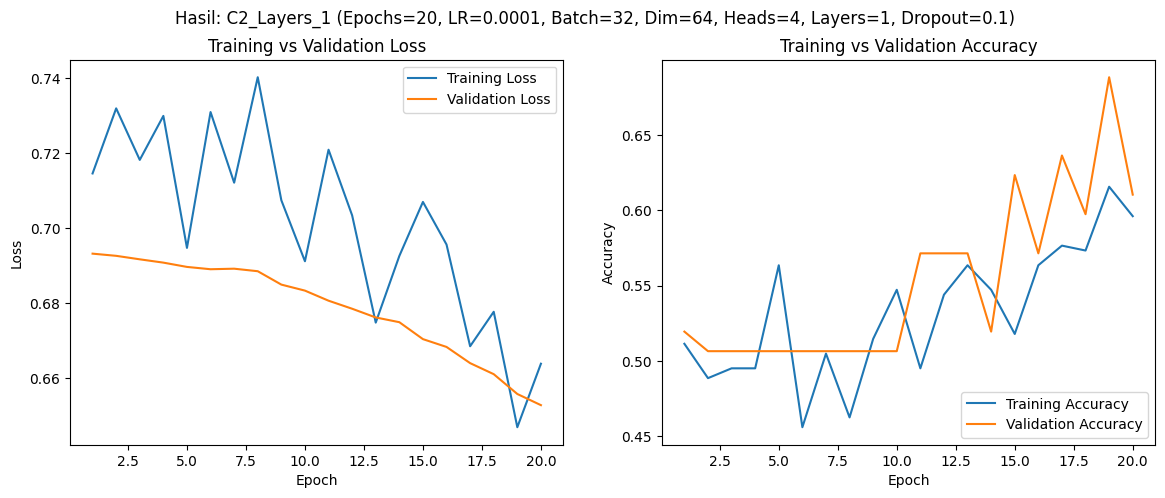

Grafik disimpan sebagai: hasil_c2_layers_1_(epochs20,_lr00001,_batch32,_dim64,_heads4,_layers1,_dropout01).png

MULAI EKSPERIMEN: C2_Layers_4
Konfigurasi: {'lr': 0.0001, 'batch_size': 32, 'embed_dim': 64, 'n_heads': 4, 'num_layers': 4, 'ff_dim': 128, 'dropout': 0.1, 'epochs': 20, 'weight_decay': 0.0, 'name': 'C2_Layers_4'}


Epoch 1/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.7170 | Train Acc: 0.5309 | Val Loss: 0.6949 | Val Acc: 0.5325


Epoch 2/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.7390 | Train Acc: 0.4756 | Val Loss: 0.6894 | Val Acc: 0.5195


Epoch 3/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.7213 | Train Acc: 0.4625 | Val Loss: 0.6856 | Val Acc: 0.6104


Epoch 4/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.7196 | Train Acc: 0.4560 | Val Loss: 0.6875 | Val Acc: 0.5065


Epoch 5/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.6905 | Train Acc: 0.5472 | Val Loss: 0.6842 | Val Acc: 0.5065


Epoch 6/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.6809 | Train Acc: 0.6156 | Val Loss: 0.6778 | Val Acc: 0.5455


Epoch 7/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.6975 | Train Acc: 0.5309 | Val Loss: 0.6723 | Val Acc: 0.6494


Epoch 8/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.6747 | Train Acc: 0.5798 | Val Loss: 0.6763 | Val Acc: 0.5065


Epoch 9/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.7094 | Train Acc: 0.5309 | Val Loss: 0.6641 | Val Acc: 0.6623


Epoch 10/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.6760 | Train Acc: 0.5961 | Val Loss: 0.6585 | Val Acc: 0.7013


Epoch 11/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.6631 | Train Acc: 0.5765 | Val Loss: 0.6549 | Val Acc: 0.6364


Epoch 12/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.6762 | Train Acc: 0.5440 | Val Loss: 0.6564 | Val Acc: 0.5195


Epoch 13/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.6510 | Train Acc: 0.6189 | Val Loss: 0.6374 | Val Acc: 0.8052


Epoch 14/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.6664 | Train Acc: 0.6091 | Val Loss: 0.6284 | Val Acc: 0.7922


Epoch 15/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.6399 | Train Acc: 0.6450 | Val Loss: 0.6227 | Val Acc: 0.6883


Epoch 16/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.6316 | Train Acc: 0.6189 | Val Loss: 0.6014 | Val Acc: 0.8182


Epoch 17/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.6196 | Train Acc: 0.7003 | Val Loss: 0.5809 | Val Acc: 0.8701


Epoch 18/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.5965 | Train Acc: 0.6938 | Val Loss: 0.5593 | Val Acc: 0.7922


Epoch 19/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.5765 | Train Acc: 0.7199 | Val Loss: 0.5259 | Val Acc: 0.8701


Epoch 20/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.5380 | Train Acc: 0.7818 | Val Loss: 0.4898 | Val Acc: 0.8701

--- Hasil Eksperimen: C2_Layers_4 ---
Waktu Training Total: 611.49 detik
Final Train Loss: 0.5380
Final Train Acc: 0.7818
Final Val Loss: 0.4898
Final Val Acc: 0.8701


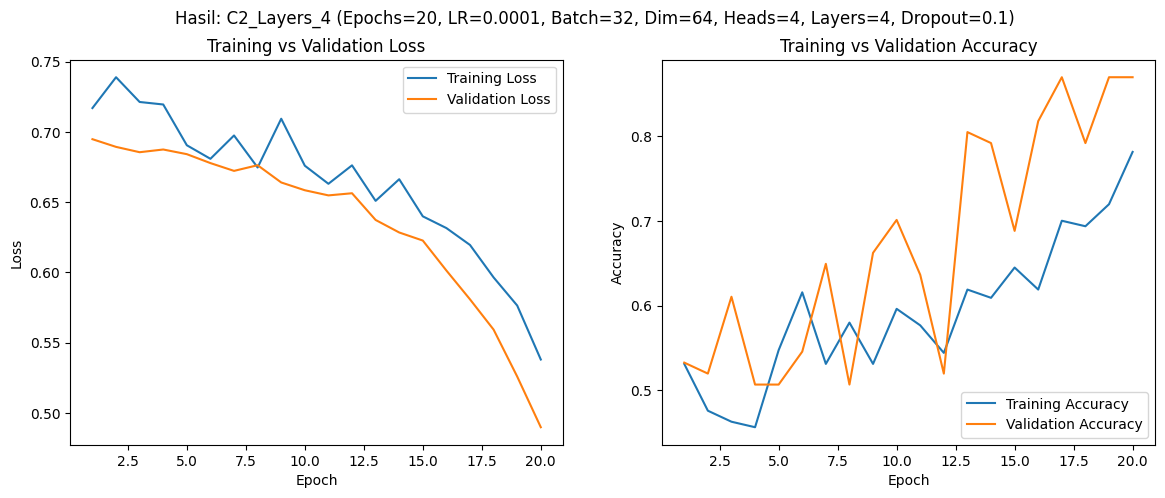

Grafik disimpan sebagai: hasil_c2_layers_4_(epochs20,_lr00001,_batch32,_dim64,_heads4,_layers4,_dropout01).png

MULAI EKSPERIMEN: C2_Embed_128
Konfigurasi: {'lr': 0.0001, 'batch_size': 32, 'embed_dim': 128, 'n_heads': 4, 'num_layers': 2, 'ff_dim': 256, 'dropout': 0.1, 'epochs': 20, 'weight_decay': 0.0, 'name': 'C2_Embed_128'}


Epoch 1/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.8289 | Train Acc: 0.5016 | Val Loss: 0.7054 | Val Acc: 0.5065


Epoch 2/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.7155 | Train Acc: 0.5212 | Val Loss: 0.7300 | Val Acc: 0.5065


Epoch 3/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.6992 | Train Acc: 0.5700 | Val Loss: 0.6850 | Val Acc: 0.5584


Epoch 4/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.6799 | Train Acc: 0.5798 | Val Loss: 0.6806 | Val Acc: 0.7013


Epoch 5/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.7013 | Train Acc: 0.5114 | Val Loss: 0.6776 | Val Acc: 0.5714


Epoch 6/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.6874 | Train Acc: 0.5505 | Val Loss: 0.6733 | Val Acc: 0.5844


Epoch 7/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.6771 | Train Acc: 0.5798 | Val Loss: 0.6575 | Val Acc: 0.6364


Epoch 8/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.6518 | Train Acc: 0.6156 | Val Loss: 0.6408 | Val Acc: 0.6883


Epoch 9/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.6386 | Train Acc: 0.6417 | Val Loss: 0.6241 | Val Acc: 0.6883


Epoch 10/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.6304 | Train Acc: 0.6612 | Val Loss: 0.5808 | Val Acc: 0.7532


Epoch 11/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.5974 | Train Acc: 0.6743 | Val Loss: 0.5412 | Val Acc: 0.7662


Epoch 12/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.5489 | Train Acc: 0.7492 | Val Loss: 0.4874 | Val Acc: 0.7662


Epoch 13/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.4997 | Train Acc: 0.7524 | Val Loss: 0.4309 | Val Acc: 0.8312


Epoch 14/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.4369 | Train Acc: 0.8111 | Val Loss: 0.3399 | Val Acc: 0.8701


Epoch 15/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.3788 | Train Acc: 0.8436 | Val Loss: 0.2999 | Val Acc: 0.9351


Epoch 16/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.3340 | Train Acc: 0.8404 | Val Loss: 0.3008 | Val Acc: 0.8312


Epoch 17/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.3765 | Train Acc: 0.8241 | Val Loss: 0.2656 | Val Acc: 0.9221


Epoch 18/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.3042 | Train Acc: 0.8599 | Val Loss: 0.2478 | Val Acc: 0.8701


Epoch 19/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.2561 | Train Acc: 0.8958 | Val Loss: 0.2389 | Val Acc: 0.9221


Epoch 20/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.2474 | Train Acc: 0.9121 | Val Loss: 0.2339 | Val Acc: 0.9221

--- Hasil Eksperimen: C2_Embed_128 ---
Waktu Training Total: 642.84 detik
Final Train Loss: 0.2474
Final Train Acc: 0.9121
Final Val Loss: 0.2339
Final Val Acc: 0.9221


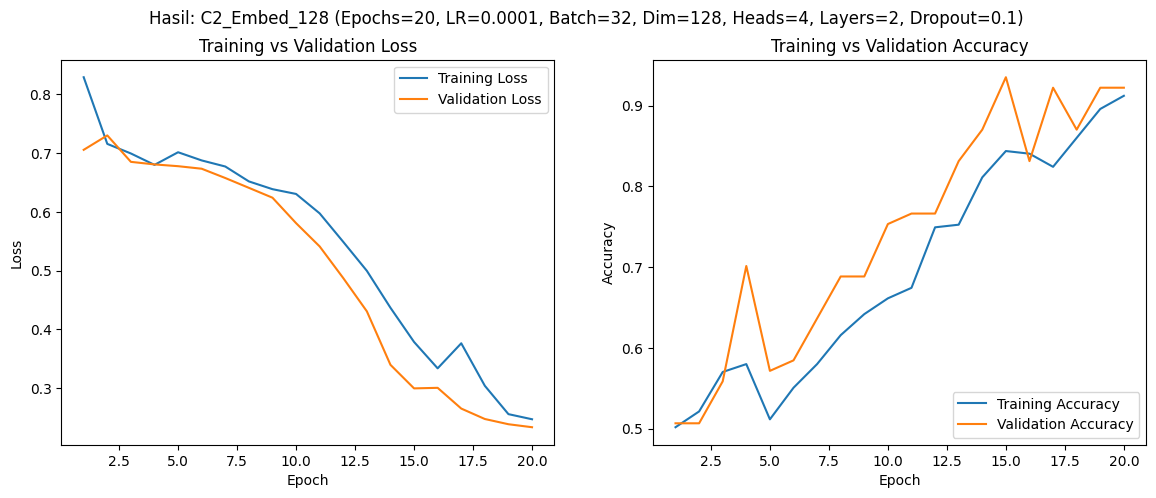

Grafik disimpan sebagai: hasil_c2_embed_128_(epochs20,_lr00001,_batch32,_dim128,_heads4,_layers2,_dropout01).png

MULAI EKSPERIMEN: C2_Embed_256
Konfigurasi: {'lr': 0.0001, 'batch_size': 32, 'embed_dim': 256, 'n_heads': 4, 'num_layers': 2, 'ff_dim': 512, 'dropout': 0.1, 'epochs': 20, 'weight_decay': 0.0, 'name': 'C2_Embed_256'}


Epoch 1/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.6962 | Train Acc: 0.5342 | Val Loss: 0.6739 | Val Acc: 0.5325


Epoch 2/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.6950 | Train Acc: 0.5342 | Val Loss: 0.6582 | Val Acc: 0.6104


Epoch 3/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.6658 | Train Acc: 0.6091 | Val Loss: 0.6325 | Val Acc: 0.6494


Epoch 4/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.6485 | Train Acc: 0.6319 | Val Loss: 0.6123 | Val Acc: 0.6623


Epoch 5/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.6016 | Train Acc: 0.6580 | Val Loss: 0.5418 | Val Acc: 0.7532


Epoch 6/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.5307 | Train Acc: 0.7785 | Val Loss: 0.4439 | Val Acc: 0.7922


Epoch 7/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.4518 | Train Acc: 0.8013 | Val Loss: 0.3180 | Val Acc: 0.8571


Epoch 8/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.3474 | Train Acc: 0.8502 | Val Loss: 0.2579 | Val Acc: 0.8831


Epoch 9/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.2908 | Train Acc: 0.8762 | Val Loss: 0.1882 | Val Acc: 0.9221


Epoch 10/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.2090 | Train Acc: 0.9186 | Val Loss: 0.3097 | Val Acc: 0.8701


Epoch 11/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.2103 | Train Acc: 0.9088 | Val Loss: 0.1719 | Val Acc: 0.9221


Epoch 12/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.1330 | Train Acc: 0.9674 | Val Loss: 0.1040 | Val Acc: 0.9610


Epoch 13/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.0952 | Train Acc: 0.9674 | Val Loss: 0.1388 | Val Acc: 0.9610


Epoch 14/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.0941 | Train Acc: 0.9609 | Val Loss: 0.0806 | Val Acc: 0.9610


Epoch 15/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.0657 | Train Acc: 0.9739 | Val Loss: 0.0960 | Val Acc: 0.9610


Epoch 16/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.1016 | Train Acc: 0.9642 | Val Loss: 0.1895 | Val Acc: 0.9610


Epoch 17/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.1070 | Train Acc: 0.9609 | Val Loss: 0.3108 | Val Acc: 0.9221


Epoch 18/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.0721 | Train Acc: 0.9739 | Val Loss: 0.0913 | Val Acc: 0.9610


Epoch 19/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.0696 | Train Acc: 0.9739 | Val Loss: 0.1079 | Val Acc: 0.9740


Epoch 20/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.0434 | Train Acc: 0.9837 | Val Loss: 0.1794 | Val Acc: 0.9610

--- Hasil Eksperimen: C2_Embed_256 ---
Waktu Training Total: 528.87 detik
Final Train Loss: 0.0434
Final Train Acc: 0.9837
Final Val Loss: 0.1794
Final Val Acc: 0.9610


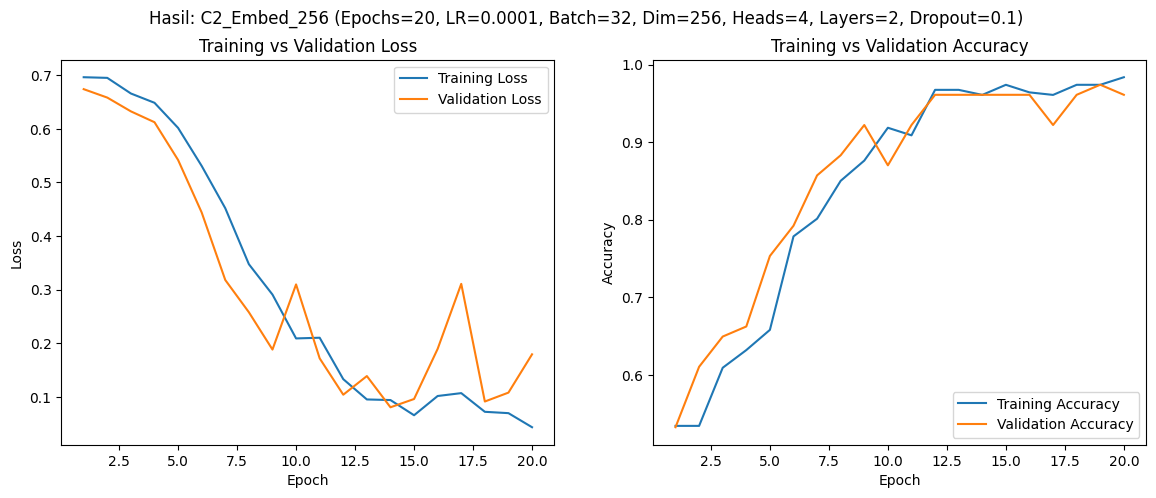

Grafik disimpan sebagai: hasil_c2_embed_256_(epochs20,_lr00001,_batch32,_dim256,_heads4,_layers2,_dropout01).png

MULAI EKSPERIMEN: C2_Dropout_0.3
Konfigurasi: {'lr': 0.0001, 'batch_size': 32, 'embed_dim': 64, 'n_heads': 4, 'num_layers': 2, 'ff_dim': 128, 'dropout': 0.3, 'epochs': 20, 'weight_decay': 0.0, 'name': 'C2_Dropout_0.3'}


Epoch 1/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.7998 | Train Acc: 0.5081 | Val Loss: 0.6992 | Val Acc: 0.5065


Epoch 2/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.8006 | Train Acc: 0.4593 | Val Loss: 0.6982 | Val Acc: 0.5065


Epoch 3/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.7806 | Train Acc: 0.4886 | Val Loss: 0.6931 | Val Acc: 0.5065


Epoch 4/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.7182 | Train Acc: 0.5733 | Val Loss: 0.6895 | Val Acc: 0.5065


Epoch 5/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.7417 | Train Acc: 0.5244 | Val Loss: 0.6894 | Val Acc: 0.5065


Epoch 6/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.7400 | Train Acc: 0.5081 | Val Loss: 0.6863 | Val Acc: 0.5065


Epoch 7/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.7503 | Train Acc: 0.5147 | Val Loss: 0.6847 | Val Acc: 0.5065


Epoch 8/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.7655 | Train Acc: 0.4853 | Val Loss: 0.6854 | Val Acc: 0.5065


Epoch 9/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.7535 | Train Acc: 0.5342 | Val Loss: 0.6843 | Val Acc: 0.5065


Epoch 10/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.7354 | Train Acc: 0.5049 | Val Loss: 0.6833 | Val Acc: 0.5065


Epoch 11/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.7380 | Train Acc: 0.5147 | Val Loss: 0.6832 | Val Acc: 0.5065


Epoch 12/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.7309 | Train Acc: 0.5375 | Val Loss: 0.6827 | Val Acc: 0.5065


Epoch 13/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.7473 | Train Acc: 0.5212 | Val Loss: 0.6824 | Val Acc: 0.5065


Epoch 14/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.7412 | Train Acc: 0.4984 | Val Loss: 0.6820 | Val Acc: 0.5065


Epoch 15/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.7422 | Train Acc: 0.5407 | Val Loss: 0.6738 | Val Acc: 0.5455


Epoch 16/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.7400 | Train Acc: 0.5179 | Val Loss: 0.6731 | Val Acc: 0.5455


Epoch 17/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.7174 | Train Acc: 0.5212 | Val Loss: 0.6723 | Val Acc: 0.5325


Epoch 18/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.6877 | Train Acc: 0.5635 | Val Loss: 0.6734 | Val Acc: 0.5065


Epoch 19/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.7003 | Train Acc: 0.5375 | Val Loss: 0.6732 | Val Acc: 0.5065


Epoch 20/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.6870 | Train Acc: 0.5863 | Val Loss: 0.6677 | Val Acc: 0.5325

--- Hasil Eksperimen: C2_Dropout_0.3 ---
Waktu Training Total: 118.37 detik
Final Train Loss: 0.6870
Final Train Acc: 0.5863
Final Val Loss: 0.6677
Final Val Acc: 0.5325


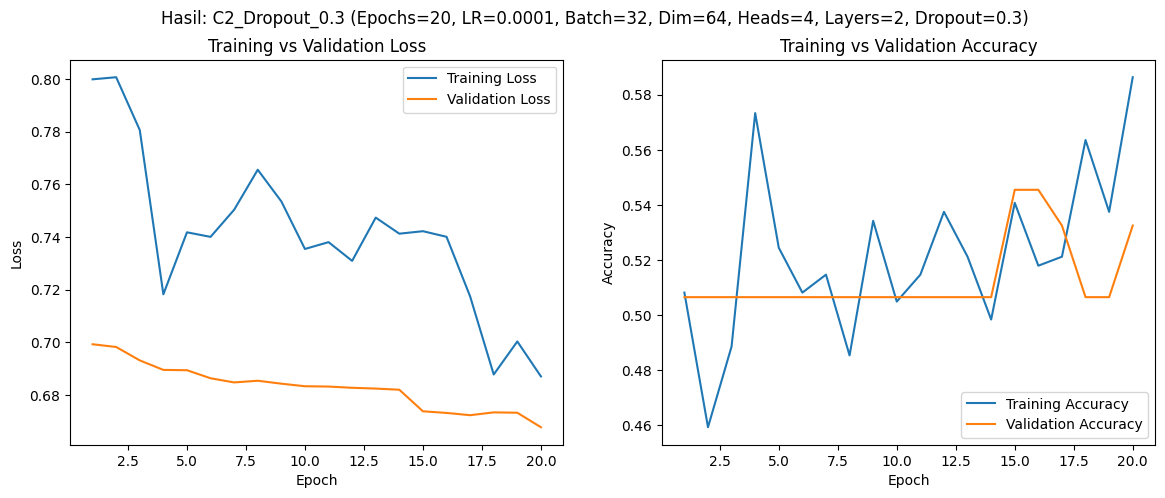

Grafik disimpan sebagai: hasil_c2_dropout_03_(epochs20,_lr00001,_batch32,_dim64,_heads4,_layers2,_dropout03).png

MULAI EKSPERIMEN: C2_Dropout_0.5
Konfigurasi: {'lr': 0.0001, 'batch_size': 32, 'embed_dim': 64, 'n_heads': 4, 'num_layers': 2, 'ff_dim': 128, 'dropout': 0.5, 'epochs': 20, 'weight_decay': 0.0, 'name': 'C2_Dropout_0.5'}


Epoch 1/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.8316 | Train Acc: 0.4951 | Val Loss: 0.7317 | Val Acc: 0.5065


Epoch 2/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.8596 | Train Acc: 0.4951 | Val Loss: 0.7146 | Val Acc: 0.5065


Epoch 3/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.8512 | Train Acc: 0.5147 | Val Loss: 0.7045 | Val Acc: 0.5065


Epoch 4/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.8655 | Train Acc: 0.5049 | Val Loss: 0.7012 | Val Acc: 0.5065


Epoch 5/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.8512 | Train Acc: 0.4658 | Val Loss: 0.6980 | Val Acc: 0.5065


Epoch 6/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.7888 | Train Acc: 0.5407 | Val Loss: 0.6965 | Val Acc: 0.5065


Epoch 7/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.8685 | Train Acc: 0.4886 | Val Loss: 0.6966 | Val Acc: 0.5065


Epoch 8/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.8576 | Train Acc: 0.4951 | Val Loss: 0.6978 | Val Acc: 0.5065


Epoch 9/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.8606 | Train Acc: 0.4625 | Val Loss: 0.7012 | Val Acc: 0.5065


Epoch 10/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.8406 | Train Acc: 0.4723 | Val Loss: 0.6974 | Val Acc: 0.5065


Epoch 11/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.7990 | Train Acc: 0.5505 | Val Loss: 0.6946 | Val Acc: 0.5065


Epoch 12/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.7769 | Train Acc: 0.5342 | Val Loss: 0.6946 | Val Acc: 0.5065


Epoch 13/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.7623 | Train Acc: 0.5570 | Val Loss: 0.6917 | Val Acc: 0.5065


Epoch 14/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.8006 | Train Acc: 0.4691 | Val Loss: 0.6905 | Val Acc: 0.5065


Epoch 15/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.7586 | Train Acc: 0.5505 | Val Loss: 0.6906 | Val Acc: 0.5065


Epoch 16/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.7912 | Train Acc: 0.5016 | Val Loss: 0.6912 | Val Acc: 0.5065


Epoch 17/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.7514 | Train Acc: 0.5537 | Val Loss: 0.6932 | Val Acc: 0.5065


Epoch 18/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.8356 | Train Acc: 0.4919 | Val Loss: 0.6964 | Val Acc: 0.5065


Epoch 19/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.7819 | Train Acc: 0.5114 | Val Loss: 0.6964 | Val Acc: 0.5065


Epoch 20/20 Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20/20 Val  :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.7871 | Train Acc: 0.5081 | Val Loss: 0.6925 | Val Acc: 0.5065

--- Hasil Eksperimen: C2_Dropout_0.5 ---
Waktu Training Total: 150.39 detik
Final Train Loss: 0.7871
Final Train Acc: 0.5081
Final Val Loss: 0.6925
Final Val Acc: 0.5065


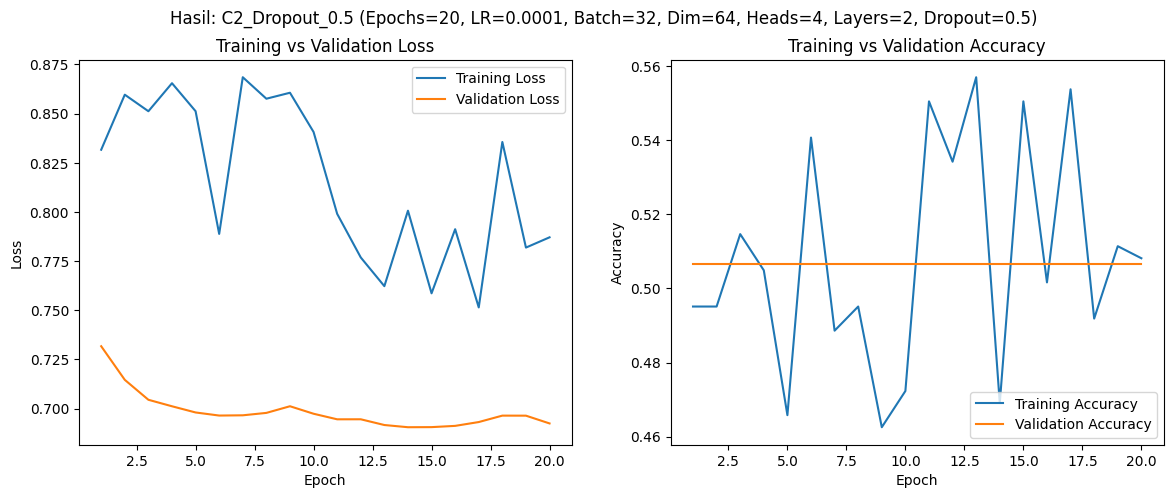

Grafik disimpan sebagai: hasil_c2_dropout_05_(epochs20,_lr00001,_batch32,_dim64,_heads4,_layers2,_dropout05).png


RINGKASAN EKSPERIMEN BAGIAN C
Nama Eksperimen           | Waktu (detik)   | Val Acc Akhir  
----------------------------------------------------------------------
C1_Epochs_50              | 307.06          | 0.8571         
C2_Heads_2                | 422.71          | 0.7922         
C2_Heads_8                | 406.20          | 0.7532         
C2_Layers_1               | 327.46          | 0.6104         
C2_Layers_4               | 611.49          | 0.8701         
C2_Embed_128              | 642.84          | 0.9221         
C2_Embed_256              | 528.87          | 0.9610         
C2_Dropout_0.3            | 118.37          | 0.5325         
C2_Dropout_0.5            | 150.39          | 0.5065         


In [11]:
# ======================================================================
# CELL 8: Bagian C - Eksperimen Hyperparameter (Baru)
# ======================================================================

def run_experiment(config, data_prep_results):
    """
    Fungsi ini menjalankan satu eksperimen penuh berdasarkan 'config'.
    """

    xm.master_print("\n" + "="*50)
    xm.master_print(f"MULAI EKSPERIMEN: {config['name']}")
    xm.master_print(f"Konfigurasi: {config}")
    xm.master_print("="*50)

    # --- 1. Ambil data yang sudah disiapkan ---
    train_dataset, val_dataset, vocab, MAX_LEN, VOCAB_SIZE, collate_fn_from_prep = data_prep_results

    # --- 2. Dapatkan device ---
    device = torch_xla.device()

    # --- 3. Buat DataLoaders ---
    train_loader_base = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, collate_fn=collate_fn_from_prep, num_workers=4)
    val_loader_base = DataLoader(val_dataset, batch_size=config['batch_size'], collate_fn=collate_fn_from_prep, num_workers=4)
    train_loader = pl.MpDeviceLoader(train_loader_base, device)
    val_loader = pl.MpDeviceLoader(val_loader_base, device)

    # --- 4. Inisialisasi Model (sesuai config) ---
    # Memanggil class dari Cell 4
    model = SentimentClassifier(
        vocab_size=VOCAB_SIZE,
        embed_dim=config['embed_dim'],
        n_heads=config['n_heads'],
        num_layers=config['num_layers'],
        ff_dim=config['ff_dim'], # Kita buat ff_dim = 2x embed_dim
        num_classes=2,
        dropout=config['dropout'],
        max_len=MAX_LEN + 1
    ).to(device)

    # --- 5. Optimizer dan Loss ---
    # Tambahkan 'weight_decay' (L2 regularization)
    optimizer = optim.Adam(model.parameters(),
                           lr=config['lr'],
                           weight_decay=config.get('weight_decay', 0.0)) # default 0
    criterion = nn.CrossEntropyLoss()

    # --- 6. Training Loop ---
    history = { 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [] }

    start_time = time.time() # Catat waktu mulai

    for epoch in range(config['epochs']):
        num_train_batches = len(train_loader_base)
        num_val_batches = len(val_loader_base)

        # Memanggil fungsi dari Cell 5
        train_loss, train_acc = train_epoch(
            model, train_loader, optimizer, criterion, device,
            num_train_batches, epoch + 1, config['epochs']
        )
        val_loss, val_acc = validate_epoch(
            model, val_loader, criterion, device,
            num_val_batches, epoch + 1, config['epochs']
        )

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print summary per epoch
        xm.master_print(f"Epoch {epoch+1}/{config['epochs']} | "
                      f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                      f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    end_time = time.time()
    total_time_sec = end_time - start_time

    # --- 7. Laporan Hasil ---
    xm.master_print(f"\n--- Hasil Eksperimen: {config['name']} ---")
    xm.master_print(f"Waktu Training Total: {total_time_sec:.2f} detik")
    xm.master_print(f"Final Train Loss: {history['train_loss'][-1]:.4f}")
    xm.master_print(f"Final Train Acc: {history['train_acc'][-1]:.4f}")
    xm.master_print(f"Final Val Loss: {history['val_loss'][-1]:.4f}")
    xm.master_print(f"Final Val Acc: {history['val_acc'][-1]:.4f}")

    # --- 8. Plot Hasil ---
    # Memanggil fungsi dari Cell 7
    plot_title = f"Hasil: {config['name']} (Epochs={config['epochs']}, LR={config['lr']}, Batch={config['batch_size']}, Dim={config['embed_dim']}, Heads={config['n_heads']}, Layers={config['num_layers']}, Dropout={config['dropout']})"
    plot_history(history, plot_title)

    xm.master_print("="*50)

    # Kembalikan metrik untuk analisis nanti
    return {
        "name": config['name'],
        "time_sec": total_time_sec,
        "history": history,
        "config": config,
        "final_val_acc": history['val_acc'][-1]
    }

# =================================================
# --- INI ADALAH EKSEKUSI UTAMA BAGIAN C ---
# =================================================
if __name__ == '__main__':
    # 1. Siapkan data SATU KALI SAJA
    xm.master_print("Menyiapkan data satu kali untuk semua eksperimen...")
    # 'prepare_data' dipanggil lagi di sini, tapi datanya udah di-cache
    # atau bisa juga kita panggil di cell terpisah.
    # Untuk amannya, kita panggil lagi.
    data_prep_results = prepare_data()

    if data_prep_results:
        # 2. Definisikan parameter dasar
        # Ini adalah konfigurasi dari run "Good Fit" kamu sebelumnya (Bagian B)
        BASE_CONFIG = {
            'lr': 1e-4,
            'batch_size': 32,
            'embed_dim': 64,
            'n_heads': 4,
            'num_layers': 2,
            'ff_dim': 128, # akan di-override oleh embed_dim * 2
            'dropout': 0.1,
            'epochs': 20, # default 20
            'weight_decay': 0.0
        }

        # 3. Definisikan list eksperimen untuk Bagian C
        experiments_c = [
            # C.1: Ubah epoch misal sampai 50
            {**BASE_CONFIG, 'name': 'C1_Epochs_50', 'epochs': 50},

            # C.2: Variasi #heads
            {**BASE_CONFIG, 'name': 'C2_Heads_2', 'n_heads': 2},
            {**BASE_CONFIG, 'name': 'C2_Heads_8', 'n_heads': 8},

            # C.2: Variasi #layers
            {**BASE_CONFIG, 'name': 'C2_Layers_1', 'num_layers': 1},
            {**BASE_CONFIG, 'name': 'C2_Layers_4', 'num_layers': 4},

            # C.2: Variasi embed_dim
            {**BASE_CONFIG, 'name': 'C2_Embed_128', 'embed_dim': 128, 'ff_dim': 256},
            {**BASE_CONFIG, 'name': 'C2_Embed_256', 'embed_dim': 256, 'ff_dim': 512},

            # C.2: Variasi dropout
            {**BASE_CONFIG, 'name': 'C2_Dropout_0.3', 'dropout': 0.3},
            {**BASE_CONFIG, 'name': 'C2_Dropout_0.5', 'dropout': 0.5},
        ]

        # 4. Jalankan semua eksperimen
        results_c = []
        for config in experiments_c:
            config['ff_dim'] = config['embed_dim'] * 2

            if config['embed_dim'] % config['n_heads'] != 0:
                xm.master_print(f"Skipping config: {config['name']} karena embed_dim {config['embed_dim']} tidak bisa dibagi n_heads {config['n_heads']}")
                continue

            result = run_experiment(config, data_prep_results)
            results_c.append(result)

        # 5. Tampilkan ringkasan Bagian C
        if torch_xla.runtime.global_ordinal() == 0:
            xm.master_print("\n\n" + "="*70)
            xm.master_print("RINGKASAN EKSPERIMEN BAGIAN C")
            xm.master_print("="*70)
            xm.master_print(f"{'Nama Eksperimen':<25} | {'Waktu (detik)':<15} | {'Val Acc Akhir':<15}")
            xm.master_print("-"*70)
            for res in results_c:
                xm.master_print(f"{res['name']:<25} | {res['time_sec']:<15.2f} | {res['final_val_acc']:<15.4f}")

    else:
        xm.master_print("Gagal menyiapkan data. Eksperimen dibatalkan.")